<a href="https://colab.research.google.com/github/juwetta/DLI_Group-B/blob/main/DLI_Malicious_URL__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Google Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [11]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import xgboost as xgb

# set paths

In [12]:
# Paths
SRC = '/content/drive/MyDrive/DLI Group B/url_dataset/URL dataset.csv'
OUT_DIR = '/content/drive/MyDrive/DLI Group B/url_dataset/clean_balanced'
FINAL_CSV = f'{OUT_DIR}/URL_dataset_clean_balanced.csv'

# Create output folder
import os
os.makedirs(OUT_DIR, exist_ok=True)


#1) Load, clean, and deduplicate

In [13]:
import pandas as pd

# Load
df = pd.read_csv(SRC)

#Convert datatype
X_text = df['url'].astype(str)
y      = df['type']

# Clean: drop missing & exact duplicates
df = df.dropna(subset=['url','type']).drop_duplicates().reset_index(drop=True)

# Show cleaned stats
print('After cleaning:', df.shape)
print('Class counts (cleaned):\n', df['type'].value_counts())

# Find minority count (phishing ~104k in your data)
minority_count = df['type'].value_counts().min()

# Undersample each class to the minority count (no synthetic data)
df_balanced = (
    df.groupby('type', group_keys=False)
      .apply(lambda x: x.sample(n=minority_count, random_state=42))
      .sample(frac=1, random_state=42)   # shuffle
      .reset_index(drop=True)
)

# Sanity checks
print('\nBalanced counts:\n', df_balanced['type'].value_counts())
print('Missing values:\n', df_balanced.isnull().sum())
print('Duplicate rows:', df_balanced.duplicated().sum())

# Save final balanced & clean file
df_balanced.to_csv(FINAL_CSV, index=False)
print('\nSaved ->', FINAL_CSV)


After cleaning: (450176, 2)
Class counts (cleaned):
 type
legitimate    345738
phishing      104438
Name: count, dtype: int64

Balanced counts:
 type
phishing      104438
legitimate    104438
Name: count, dtype: int64
Missing values:
 url     0
type    0
dtype: int64


/tmp/ipython-input-412539766.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=minority_count, random_state=42))


Duplicate rows: 0

Saved -> /content/drive/MyDrive/DLI Group B/url_dataset/clean_balanced/URL_dataset_clean_balanced.csv


# Make dataset memory friendly

[Temp] loading data from github


In [14]:
DATA_URL = "https://raw.githubusercontent.com/juwetta/DLI_Group-B/main/URL_dataset_clean_balanced.csv"
!wget -O URL_dataset_clean_balanced.csv "$DATA_URL"

df = pd.read_csv("URL_dataset_clean_balanced.csv")

X_text = df['url'].astype(str)
y      = df['type']           # strings: "phishing", "legitimate

--2025-08-24 08:41:26--  https://raw.githubusercontent.com/juwetta/DLI_Group-B/main/URL_dataset_clean_balanced.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15312637 (15M) [text/plain]
Saving to: ‘URL_dataset_clean_balanced.csv’

URL_dataset_clean_b 100%[===================>]  14.60M  --.-KB/s    in 0.1s    

2025-08-24 08:41:26 (134 MB/s) - ‘URL_dataset_clean_balanced.csv’ saved [15312637/15312637]



#2) Stratified train/val/test splits



In [15]:
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)
print(len(X_train_text), len(X_test_text), y_train.value_counts().to_dict())

# train_df, temp_df = train_test_split(
#     df_balanced, test_size=0.30, stratify=df_balanced['type'], random_state=42
# )
# val_df, test_df = train_test_split(
#     temp_df, test_size=0.50, stratify=temp_df['type'], random_state=42
# )

# print('Split sizes -> train/val/test:', len(train_df), len(val_df), len(test_df))
# print('Train counts:\n', train_df['type'].value_counts())
# print('Val counts:\n',   val_df['type'].value_counts())
# print('Test counts:\n',  test_df['type'].value_counts())

# train_df.to_csv(f'{OUT_DIR}/URL_dataset_balanced_train.csv', index=False)
# val_df.to_csv(f'{OUT_DIR}/URL_dataset_balanced_val.csv', index=False)
# test_df.to_csv(f'{OUT_DIR}/URL_dataset_balanced_test.csv', index=False)
# print('\nSaved splits to:', OUT_DIR)


167100 41776 {'legitimate': 83550, 'phishing': 83550}


# Make dataset memory friendly

In [16]:
# Smaller TF-IDF to avoid RAM issues
tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3,4),
    min_df=5,
    max_features=10000,
    dtype=np.float32
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

# Reduce to 200 dims (dense but tiny)
svd = TruncatedSVD(n_components=200, random_state=42)
X_train_200 = svd.fit_transform(X_train_tfidf)
X_test_200  = svd.transform(X_test_tfidf)

print("Shapes ->", X_train_200.shape, X_test_200.shape)

Shapes -> (167100, 200) (41776, 200)


# 3) Train Model: XGBoost (hist) on 200-D

3.1) Label Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

# y_train / y_test are strings -> encode to 0/1
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # e.g., legitimate->0, phishing->1
y_test_enc  = le.transform(y_test)

print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Classes mapping: {'legitimate': np.int64(0), 'phishing': np.int64(1)}


In [18]:
# ---- XGBoost fit ----
xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    learning_rate=0.08,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_200, y_train_enc)

# Default-threshold predictions (0/1)
y_pred_enc = xgb_model.predict(X_test_200)

# OPTIONAL: map back to strings for reports
y_pred = le.inverse_transform(y_pred_enc)

# 4) Evaluate Model

In [19]:
import numpy as np
from sklearn.metrics import f1_score

proba = xgb_model.predict_proba(X_test_200)[:, 1]   # P(class=1)
phish_id = le.transform(['phishing'])[0]

best_f1, best_t = 0, 0.5
for t in np.arange(0.30, 0.71, 0.01):
    y_pred_t = (proba >= t).astype(int)
    f1 = f1_score(y_test_enc, y_pred_t, pos_label=phish_id)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Best F1={best_f1:.4f} at threshold={best_t:.2f}")

# If you want the string labels for that best threshold:
y_pred_best = le.inverse_transform((proba >= best_t).astype(int))
print(classification_report(y_test, y_pred_best, digits=3))

Best F1=0.9966 at threshold=0.41
              precision    recall  f1-score   support

  legitimate      0.994     0.999     0.997     20888
    phishing      0.999     0.994     0.997     20888

    accuracy                          0.997     41776
   macro avg      0.997     0.997     0.997     41776
weighted avg      0.997     0.997     0.997     41776



In [20]:
try:
    X_TR, X_TE = X_train_200, X_test_200
except NameError:
    X_TR, X_TE = X_train, X_test

# Targets
y_TR, y_TE = y_train, y_test

+---------------+------------+-------------+----------+------------+-----------+------------------------+-----------------+
| Model         |   Accuracy |   Precision |   Recall |   F1 Score |   ROC-AUC | Params                 |   Inference(ms) |
+===============+============+=============+==========+============+===========+========================+=================+
| XGBClassifier |     99.651 |      99.899 |   99.402 |      99.65 |    99.949 | trees=250, max_depth=7 |            0.01 |
+---------------+------------+-------------+----------+------------+-----------+------------------------+-----------------+


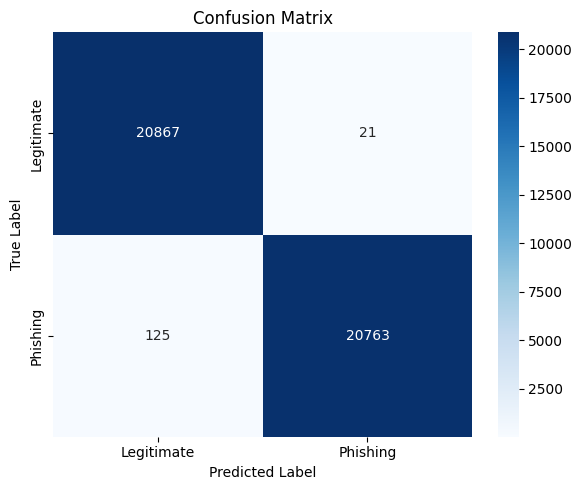

In [21]:
import time, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tabulate import tabulate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# Helper: convert labels to ints; also return pretty axis names
def to_int_and_names(y, positive_label="phishing"):
    y = np.asarray(y)
    if y.dtype.kind in "OUS":        # string/object labels
        y_int = (y == positive_label).astype(int)
        names = ("Legitimate", "Phishing")
    else:                            # numeric 0/1
        y_int = y.astype(int)
        names = ("Class 0", "Class 1")
    return y_int, names

# Inference & predictions
t0 = time.time()
y_pred = xgb_model.predict(X_TE)
t1 = time.time()
inference_ms = (t1 - t0) / len(y_TE) * 1000

# Normalize labels/preds to ints for metrics, and get axis names
y_true_int, axis_names = to_int_and_names(y_TE)
if np.asarray(y_pred).dtype.kind in "OUS":
    y_pred_int, _ = to_int_and_names(y_pred)
else:
    y_pred_int = np.asarray(y_pred).astype(int)

# Metrics (percent)
acc  = accuracy_score(y_true_int, y_pred_int) * 100
prec = precision_score(y_true_int, y_pred_int, zero_division=0) * 100
rec  = recall_score(y_true_int, y_pred_int, zero_division=0) * 100
f1   = f1_score(y_true_int, y_pred_int, zero_division=0) * 100

# ROC-AUC (if predict_proba available)
try:
    y_prob = xgb_model.predict_proba(X_TE)[:, 1]
    roc_auc = roc_auc_score(y_true_int, y_prob) * 100
    roc_str = f"{roc_auc:.3f}"
except Exception:
    roc_str = "N/A"

# Build & print ASCII table
results = pd.DataFrame([{
    "Model": type(xgb_model).__name__,
    "Accuracy": f"{acc:.3f}",
    "Precision": f"{prec:.3f}",
    "Recall": f"{rec:.3f}",
    "F1 Score": f"{f1:.3f}",
    "ROC-AUC": roc_str,
    "Params": f"trees={xgb_model.n_estimators}, max_depth={xgb_model.max_depth}",
    "Inference(ms)": f"{inference_ms:.3f}"
}])
print(tabulate(results, headers="keys", tablefmt="grid", showindex=False))

# Confusion Matrix (and save)
cm = confusion_matrix(y_true_int, y_pred_int, labels=[0, 1])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[axis_names[0], axis_names[1]],
            yticklabels=[axis_names[0], axis_names[1]])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()

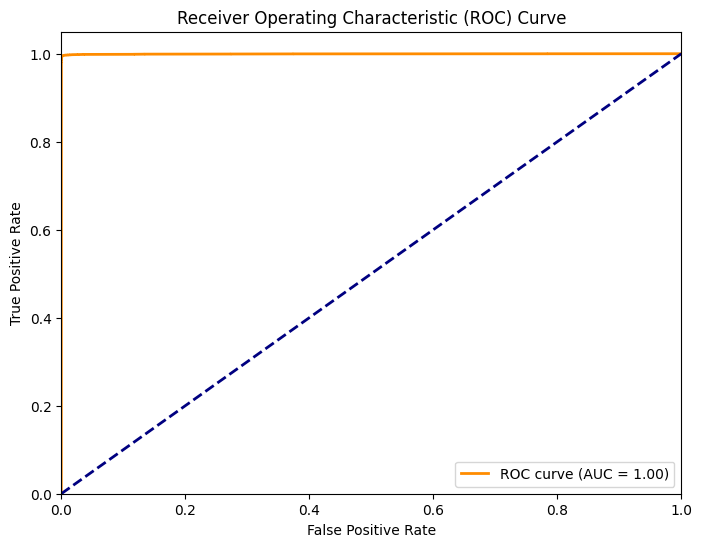

In [23]:
#Insert ROC Curve(and save)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_int, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()